In [1]:
%matplotlib inline
import collections
import glob
import h5py
import os
import re
import warnings
import numpy as np
import matplotlib.gridspec as gridspec
import TwissTable as tt
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import interpolate

In [2]:
madx_folder = "madx_run_III"
plane = "V"

In [3]:
# Function definitions

def gauss(x, a, b, c, d, e):
    return a*np.exp(-(x - b) ** 2 / (2 * c ** 2)) + d * x + e

def get_beta(run, plane):
    data_path = os.path.join("..", "madx", run)
    files = os.listdir(data_path)

    ctimes = []
    beta_x_h = []
    alpha_x_h = []
    beta_y_h = []
    alpha_y_h = []

    beta_x_v = []
    alpha_x_v = []
    beta_y_v = []
    alpha_y_v = []

    for f in files:
        if f.startswith("output"):
            ctime = re.search("R3_(.*)_0", f).group(1)
            file_path = os.path.join(data_path, f)
            tab = tt.TwissTable(file_path)
            tab.convertToNumpy()
            
            ws_h = tab.findDataIndex("NAME", "BR3.BWS.2L1.H_ROT")[0]

            ws_h_betx = tab.data["BETX"][ws_h]
            ws_h_bety = tab.data["BETY"][ws_h]
            ws_h_alphax = tab.data["ALFX"][ws_h]
            ws_h_alphay = tab.data["ALFY"][ws_h]
            ws_h_disp = tab.data["DISP"][ws_h]

            ctimes.append(ctime)
            beta_x_h.append(ws_h_betx)
            alpha_x_h.append(ws_h_alphax)
            beta_y_h.append(ws_h_bety)
            alpha_y_h.append(ws_h_alphay)
            
            
            ws_v = tab.findDataIndex("NAME", "BR3.BWS.2L1.V_ROT")[0]

            ws_v_betx = tab.data["BETX"][ws_v]
            ws_v_bety = tab.data["BETY"][ws_v]
            ws_v_alphax = tab.data["ALFX"][ws_v]
            ws_v_alphay = tab.data["ALFY"][ws_v]
            ws_v_disp = tab.data["DISP"][ws_v]

            beta_x_v.append(ws_v_betx)
            alpha_x_v.append(ws_v_alphax)
            beta_y_v.append(ws_v_bety)
            alpha_y_v.append(ws_v_alphay)
            

    if plane == "H":
        return ctimes, beta_x_h

    elif plane == "V":
        return ctimes, beta_y_v


def apply_fit(function, data_1, data_2, ind_var):
    
    mu_y = max(data_2)
    min_y = min(data_2)
    data_x = []
    data_y = []
    mu_x = []
    for x, y in zip(data_1, data_2):
        if y == mu_y:
            mu_x.append(x)
    for x, y in zip(data_1, data_2):
        if x - mu_x[0] > -20 and x - mu_x[0] < 20:
            data_x.append(x - mu_x[0])
            data_y.append((y - min_y) / mu_y)
    
    if ind_var == "space":
        try:
            popt, pcov = curve_fit(function, np.asarray(data_x), np.asarray(data_y))
            return np.asarray(data_x), np.asarray(data_y), popt, pcov
        except:
            print("")
            print("Fit of profile failed.")
            print("")
            return "NaN", "NaN"
        
        
def calculate_emittance(data_dict, sel_ctime, madx_folder, plane):
    sigma_wire = np.asarray(data_dict["sw"])
    sigma_grid_1 = np.asarray(data_dict["s1"])
    sigma_grid_2 = np.asarray(data_dict["s2"])
    sigma_grid_3 = np.asarray(data_dict["s3"])
    intensity = np.asarray(data_dict["i"])

    int_new = [x if (x > np.mean(intensity) - np.std(intensity)) else 0 for x in intensity]
    int_new = [x if (x < np.mean(intensity) + np.std(intensity)) else 0 for x in int_new]
    print("Recorded intensities:", intensity)
    print("Intensities after outlier exclusion:", int_new)
    
#     norm_sigma_wire = (sigma_wire / intensity) * np.mean(intensity)
#     norm_sigma_grid_1 = (sigma_grid_1 / intensity) * np.mean(intensity)
#     norm_sigma_grid_2 = (sigma_grid_2 / intensity) * np.mean(intensity)
#     norm_sigma_grid_3 = (sigma_grid_3 / intensity) * np.mean(intensity)
    
    ct_ws, beta_ws = get_beta(madx_folder, plane)
    
    fun_beta = interpolate.interp1d(np.asarray(ct_ws, dtype="float64"), beta_ws, kind='linear', fill_value='extrapolate')
    
    beta_wire = fun_beta(sel_ctime)
    print("Beta wire:", beta_wire)
    
    data = h5py.File("../beta_gamma.hdf5", 'r')
    ctime = np.asarray(list(data["ctime"]))
    beta = np.asarray(list(data["beta"]))
    gamma = np.asarray(list(data["gamma"]))
    
    beta_gamma = []
    
    for ct, b, g in zip(ctime, beta, gamma):
        if ct == sel_ctime:
            beta_gamma.append(b)
            beta_gamma.append(g)
            
    beta_rel = beta_gamma[0]    
    gamma_rel = beta_gamma[1]
    
    print("Beta rel:", beta_rel, "Gamma rel:", gamma_rel)
    
#     norm_emittance_wire = ((norm_sigma_wire)**2 / beta_wire) * beta_rel * gamma_rel
    emittance_wire = ((sigma_wire)**2 / beta_wire) * beta_rel * gamma_rel
    norm_emittance_wire = []
    for e, i in zip(emittance_wire, int_new):
        print(e, i)
        if i != 0:
            n_em = (e/i)*np.mean(int_new)
            norm_emittance_wire.append(n_em)
        else:
            print("An intensity value was excluded.")
    
    print("")
    print("Normal emittance:", emittance_wire, np.mean(emittance_wire), np.std(emittance_wire, dtype=np.float64))
    print("Normalized emittance:", norm_emittance_wire, np.mean(norm_emittance_wire), np.std(norm_emittance_wire, dtype=np.float64))
    print("Intensity:", intensity)
    print("")
    
    e_norm = [x for x in norm_emittance_wire if (x > np.mean(norm_emittance_wire) - 2 * np.std(norm_emittance_wire))]
    e_norm = [x for x in e_norm if (x < np.mean(norm_emittance_wire) + 2 * np.std(norm_emittance_wire))]
   
    print("Outliers excluded:", e_norm, np.mean(e_norm), np.std(e_norm, dtype=np.float64))
          
    return beta_wire, beta_rel, gamma_rel, np.mean(e_norm), np.std(e_norm, dtype=np.float64), np.mean(emittance_wire), np.std(emittance_wire, dtype=np.float64), np.mean(sigma_wire), np.std(sigma_wire), np.mean(intensity), np.std(intensity)  

def get_data(directory, sel_ctime):
#     plane = re.search('PROFILE_(.*)_2018', directory).group(1).replace("_", " ")
#     beam = re.search('(.*)_PROFILE', directory).group(1)
    bct_files = glob.glob(os.path.join(data_path, directory, "bct_shot*"))
    ws_files = glob.glob(os.path.join(data_path, directory, "wirescanner_shot*"))
    sem_files = glob.glob(os.path.join(data_path, directory, "semgrid_shot*"))
    
    bct_dict = collections.defaultdict(list)
    ws_dict = collections.defaultdict(list)
    sem_dict = collections.defaultdict(list)
    data_dict = collections.defaultdict(list)
    
    shots_bct = []
    shots_ws = []
    shots_sem = []
    
    for fb in bct_files:
        data_bct = h5py.File(fb, 'r')
        x = np.asarray(list(data_bct["ctime"]))
        y = np.asarray(list(data_bct["intensity"]))
        shot_bct = re.search('shot_(.*)_R', fb).group(1)
        shots_bct.append(shot_bct)
        bct_dict[(str(shot_bct), "x")] = x
        bct_dict[(str(shot_bct), "y")] = y
        
    for fw in ws_files:
        data_ws = h5py.File(fw, 'r')
        shot_ws = re.search('shot_(.*)_R', fw).group(1)
        shots_ws.append(shot_ws)
        ws_dict[(str(shot_ws), "x")] = np.asarray(list(data_ws["position"]))
        ws_dict[(str(shot_ws), "y")] = np.asarray(list(data_ws["intensity"]))
        ws_dict[(str(shot_ws), "z")] = np.asarray(list(data_ws["time"]))
        
    for fs in sem_files:
        data_sem = h5py.File(fs, 'r')
        x1 = np.asarray(list(data_sem["sem_1_x"]))
        y1 = np.asarray(list(data_sem["sem_1_y"]))
        x2 = np.asarray(list(data_sem["sem_2_x"]))
        y2 = np.asarray(list(data_sem["sem_2_y"]))
        x3 = np.asarray(list(data_sem["sem_3_x"]))
        y3 = np.asarray(list(data_sem["sem_3_y"]))
        shot_sem = re.search('shot_(.*)_R', fs).group(1)
        shots_sem.append(shot_sem)
        sem_dict[(str(shot_sem), "x1")] = x1
        sem_dict[(str(shot_sem), "y1")] = y1
        sem_dict[(str(shot_sem), "x2")] = x2
        sem_dict[(str(shot_sem), "y2")] = y2
        sem_dict[(str(shot_sem), "x3")] = x3
        sem_dict[(str(shot_sem), "y3")] = y3
        
        
    shot_list = list(set(shots_bct) & set(shots_ws) & set(shots_sem))

    for shot in shot_list:
        fig = plt.figure()
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        plt.rcParams["figure.figsize"] = [10, 3]
        
        intensity = []
        for x_bct, y_bct in zip(bct_dict[(shot, "x")],  bct_dict[(shot, "y")]):
            if x_bct == sel_ctime:
                intensity.append(y_bct)
        ax1.scatter(bct_dict[(shot, "x")], bct_dict[(shot, "y")], s=0.3, color="black", label=str(intensity[0]))
        ax1.set_xlabel('ctime [ms]')
        ax1.set_ylabel(r'Intensity [$10^{10}$]')
        ax1.legend(fontsize=10, loc="upper right")
        
        x, y, popt, pcov = apply_fit(gauss, ws_dict[(shot, "x")]*1e-3, ws_dict[(shot, "y")], "space")
        perr = np.sqrt(np.diag(pcov))
        fit = r"$\sigma={:.3f}\pm{:.3f}$".format(popt[2], perr[2])
        
        ax2.scatter(x, y, s=0.3, color="black")
        ax2.plot(x, gauss(x, popt[0], popt[1], popt[2], popt[3], popt[4]), label=fit, lw=0.8, color='green')
        ax2.set_xlabel('Position [mm]')
        ax2.set_ylabel(r'Normalized amplitude')
        ax2.set_ylim([-0.05, max(y) + 0.2*max(y)])
        ax2.set_title(str(sel_ctime) + ", shot " + str(shot))
        ax2.legend(fontsize=10, loc="upper left")
        
        x1, y1, popt1, pcov1 = apply_fit(gauss, sem_dict[(shot, "x1")], sem_dict[(shot, "y1")], "space")
        perr1 = np.sqrt(np.diag(pcov1))
        fit1 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt1[2]), perr1[2])
        
        x2, y2, popt2, pcov2 = apply_fit(gauss, sem_dict[(shot, "x2")], sem_dict[(shot, "y2")], "space")
        perr2 = np.sqrt(np.diag(pcov2))
        fit2 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt2[2]), perr2[2])
        
        x3, y3, popt3, pcov3 = apply_fit(gauss, sem_dict[(shot, "x3")], sem_dict[(shot, "y3")], "space")
        perr3 = np.sqrt(np.diag(pcov3))
        fit3 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt3[2]), perr3[2])
        
        ax3.scatter(x1, y1, s=0.5, color='blue')
        ax3.plot(x1, gauss(x1, popt1[0], popt1[1], popt1[2], popt1[3], popt1[4]), label="Grid 1: " + fit1, lw=0.8, color='blue')
        ax3.scatter(x2, y2, s=0.5, color='green')
        ax3.plot(x2, gauss(x2, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4]), label="Grid 2: " + fit2, lw=0.8, color='green')
        ax3.scatter(x3, y3, s=0.5, color='orange')
        ax3.plot(x3, gauss(x3, popt3[0], popt3[1], popt3[2], popt3[3], popt3[4]), label="Grid 3: " + fit3, lw=0.8, color='orange')
        ax3.legend(fontsize=10, loc="upper left")
        
        ax3.set_ylim([-0.05, 2])
        
        ax3.set_xlabel('Position [mm]')
        ax3.set_ylabel(r'Normalized amplitude')
        
#         ax3.plot(sem_dict[(shot, "x1")], sem_dict[(shot, "y1")])
#         ax3.plot(sem_dict[(shot, "x2")], sem_dict[(shot, "y2")])
#         ax3.plot(sem_dict[(shot, "x3")], sem_dict[(shot, "y3")])
        
        plt.tight_layout()
        plt.show()
        
        data_dict["sw"].append(popt[2])
        data_dict["s1"].append(popt1[2])
        data_dict["s2"].append(popt2[2])
        data_dict["s3"].append(popt3[2])
        data_dict["i"].append(intensity[0])
        
    return data_dict

In [4]:
# Specify the folder where the data is with respect to the location of this notebook
data_path = os.path.join(os.getcwd(), "results")

result_folders = [x[0].strip(data_path) for x in os.walk(data_path)][1:]
# result_folders = [d for d in os.listdir(data_path) if os.path.isdir(data_path)]
# result_folders.remove('tomoscope')

print(result_folders)

['PROFILE_NOQSTRIP_TUNE_375_V_R3_2018_10_15_14_04', 'PROFILE_NOQSTRIP_TUNE_550_V_R3_2018_10_15_14_27', 'PROFILE_NOQSTRIP_TUNE_400_V_R3_2018_10_15_14_08', 'PROFILE_NOQSTRIP_TUNE_360_V_R3_2018_10_15_14_01', 'PROFILE_NOQSTRIP_TUNE_730_V_R3_2018_10_15_14_48', 'PROFILE_NOQSTRIP_TUNE_300_V_R3_2018_10_15_13_05', 'PROFILE_NOQSTRIP_TUNE_450_V_R3_2018_10_15_14_15', 'PROFILE_NOQSTRIP_TUNE_310_V_R3_2018_10_15_13_11', 'PROFILE_NOQSTRIP_TUNE_500_V_R3_2018_10_15_14_21', 'PROFILE_NOQSTRIP_TUNE_600_V_R3_2018_10_15_14_33', 'PROFILE_NOQSTRIP_TUNE_300_V_R3_2018_10_15_15_00', 'PROFILE_NOQSTRIP_TUNE_350_V_R3_2018_10_15_13_58', 'PROFILE_NOQSTRIP_TUNE_675_V_R3_2018_10_15_14_41', 'PROFILE_NOQSTRIP_TUNE_795_V_R3_2018_10_15_14_53', 'PROFILE_NOQSTRIP_TUNE_285_V_R3_2018_10_15_13_01', 'PROFILE_NOQSTRIP_TUNE_340_V_R3_2018_10_15_13_54', 'PROFILE_NOQSTRIP_TUNE_320_V_R3_2018_10_15_13_14', 'PROFILE_NOQSTRIP_TUNE_325_V_R3_2018_10_15_13_51', 'PROFILE_NOQSTRIP_TUNE_430_V_R3_2018_10_15_14_11', 'PROFILE_NOQSTRIP_TUNE_470_V_R


PROFILE_NOQSTRIP_TUNE_375_V_R3_2018_10_15_14_04


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


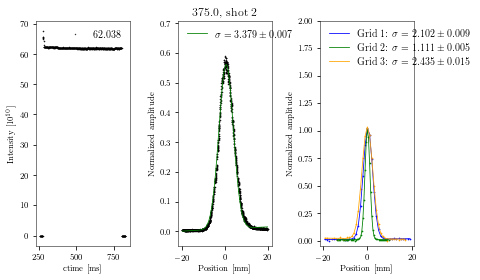

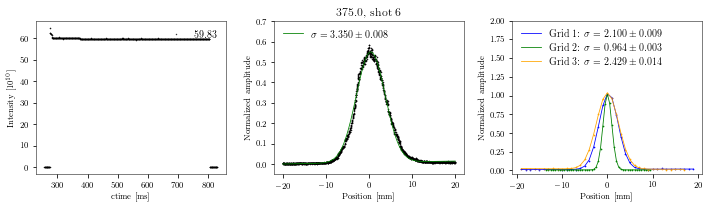

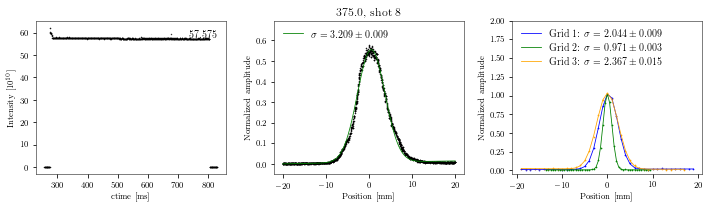

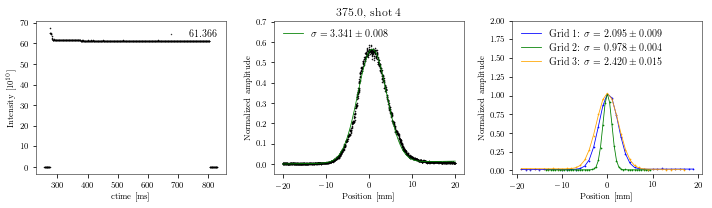

Recorded intensities: [ 62.038  59.83   57.575  61.366]
Intensities after outlier exclusion: [0, 59.829999999999998, 0, 61.366]
Beta wire: 4.1571204373
Beta rel: 0.47317 Gamma rel: 1.13511
1.47554540599 0
An intensity value was excluded.
1.45025995173 59.83
1.33011076307 0
An intensity value was excluded.
1.44212548669 61.366

Normal emittance: [ 1.47554541  1.45025995  1.33011076  1.44212549] 1.42451040187 0.0558775312237
Normalized emittance: [0.73443801232470429, 0.71203859011902493] 0.723238301222 0.0111997111028
Intensity: [ 62.038  59.83   57.575  61.366]

Outliers excluded: [0.73443801232470429, 0.71203859011902493] 0.723238301222 0.0111997111028

PROFILE_NOQSTRIP_TUNE_550_V_R3_2018_10_15_14_27


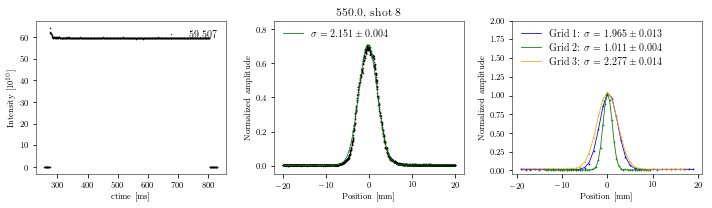

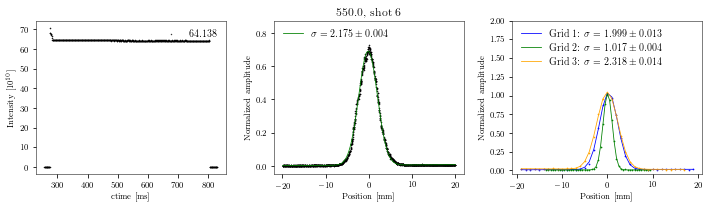

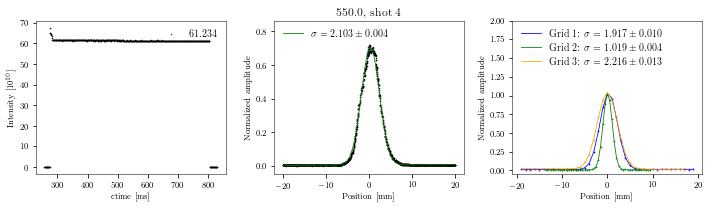

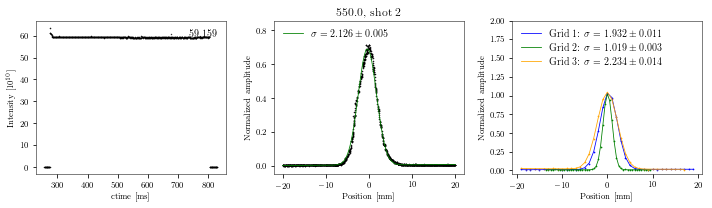

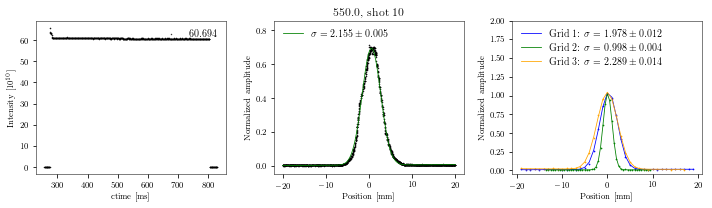

Recorded intensities: [ 59.507  64.138  61.234  59.159  60.694]
Intensities after outlier exclusion: [59.506999999999998, 0, 61.234000000000002, 0, 60.694000000000003]
Beta wire: 4.246881001849999
Beta rel: 0.78965 Gamma rel: 1.62983
1.40234347161 59.507
1.4341920058 0
An intensity value was excluded.
1.34059218714 61.234
1.37008658727 0
An intensity value was excluded.
1.40754896773 60.694

Normal emittance: [ 1.40234347  1.43419201  1.34059219  1.37008659  1.40754897] 1.39095264391 0.0323925894673
Normalized emittance: [0.85514036254899184, 0.7944290540352299, 0.84152847714621892] 0.830365964577 0.0260117538882
Intensity: [ 59.507  64.138  61.234  59.159  60.694]

Outliers excluded: [0.85514036254899184, 0.7944290540352299, 0.84152847714621892] 0.830365964577 0.0260117538882

PROFILE_NOQSTRIP_TUNE_400_V_R3_2018_10_15_14_08


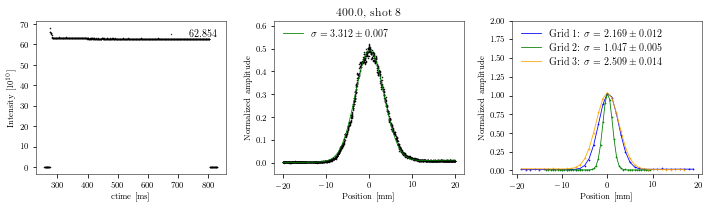

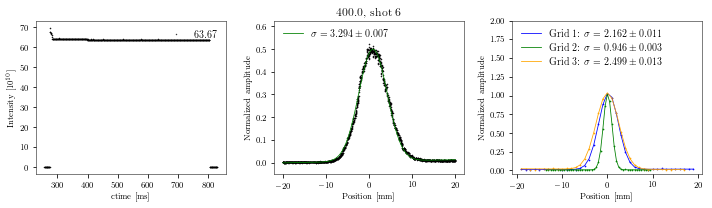

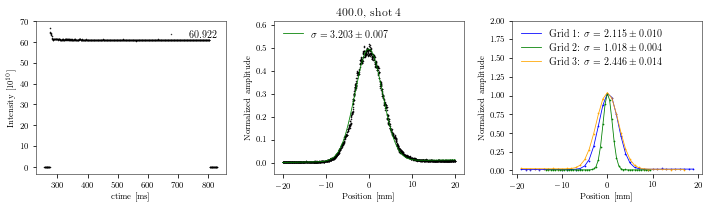

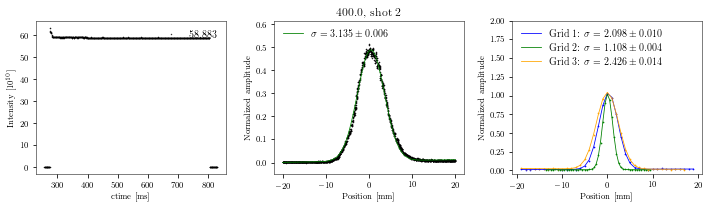

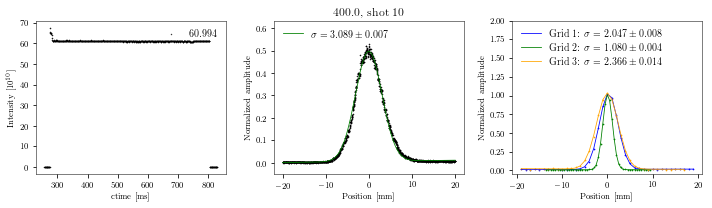

Recorded intensities: [ 62.854  63.67   60.922  58.883  60.994]
Intensities after outlier exclusion: [62.853999999999999, 0, 60.922000000000004, 0, 60.994]
Beta wire: 4.1812623962
Beta rel: 0.52149 Gamma rel: 1.17198
1.60319396601 62.854
1.58596768032 0
An intensity value was excluded.
1.49972605781 60.922
1.43697961496 0
An intensity value was excluded.
1.39458266159 60.994

Normal emittance: [ 1.60319397  1.58596768  1.49972606  1.43697961  1.39458266] 1.50408999614 0.081289920102
Normalized emittance: [0.94257214847247839, 0.90970218870452957, 0.84492585625393712] 0.899066731144 0.0405670992649
Intensity: [ 62.854  63.67   60.922  58.883  60.994]

Outliers excluded: [0.94257214847247839, 0.90970218870452957, 0.84492585625393712] 0.899066731144 0.0405670992649

PROFILE_NOQSTRIP_TUNE_360_V_R3_2018_10_15_14_01


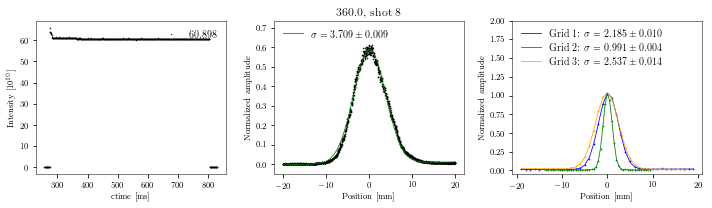

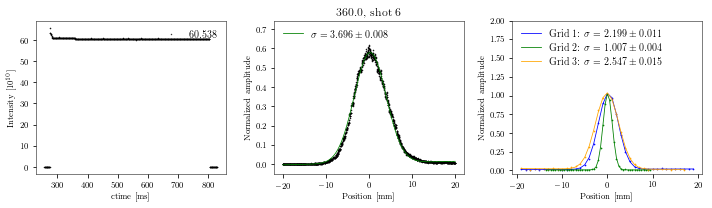

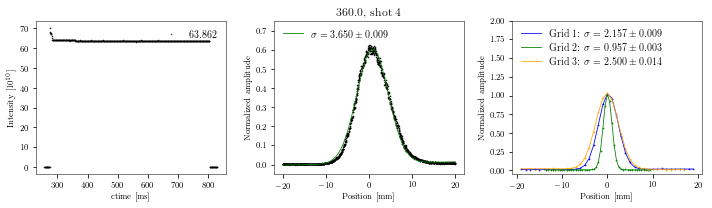

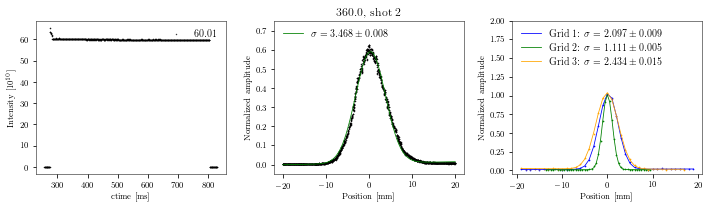

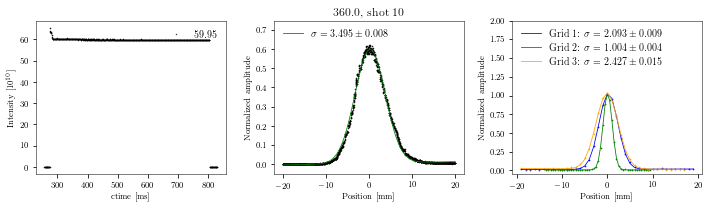

Recorded intensities: [ 60.898  60.538  63.862  60.01   59.95 ]
Intensities after outlier exclusion: [60.898000000000003, 60.538000000000004, 0, 60.009999999999998, 59.950000000000003]
Beta wire: 4.141540647499999
Beta rel: 0.44528 Gamma rel: 1.11683
1.65203458541 60.898
1.63991718958 60.538
1.59933704532 0
An intensity value was excluded.
1.44394727593 60.01
1.4666864442 59.95

Normal emittance: [ 1.65203459  1.63991719  1.59933705  1.44394728  1.46668644] 1.56038450809 0.0878401280332
Normalized emittance: [1.3097130965852031, 1.3078378866052349, 1.1616833748402347, 1.1811584349735293] 1.24009819825 0.0690247775696
Intensity: [ 60.898  60.538  63.862  60.01   59.95 ]

Outliers excluded: [1.3097130965852031, 1.3078378866052349, 1.1616833748402347, 1.1811584349735293] 1.24009819825 0.0690247775696

PROFILE_NOQSTRIP_TUNE_730_V_R3_2018_10_15_14_48


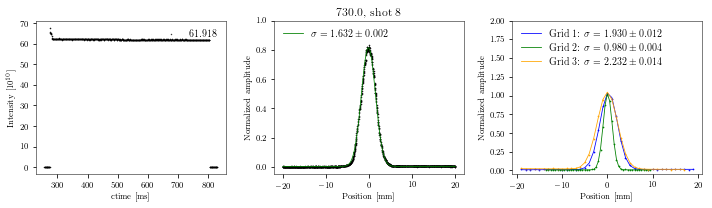

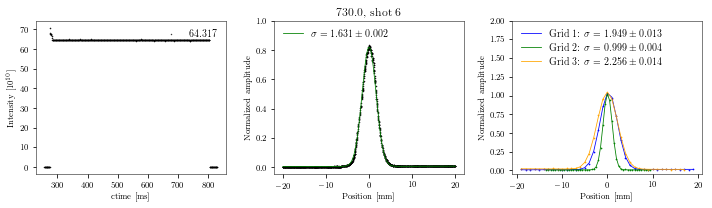

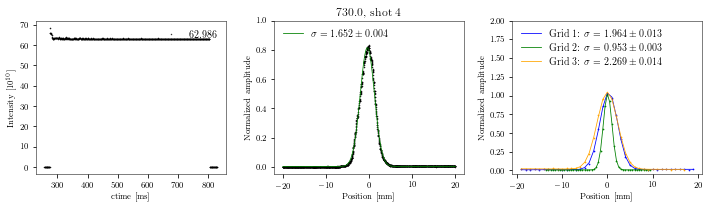

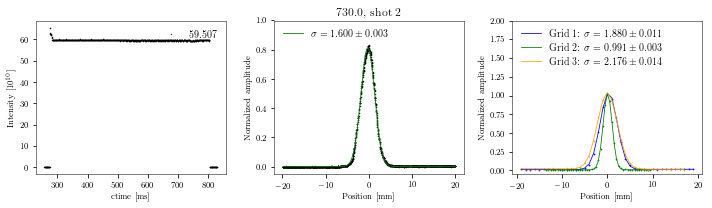

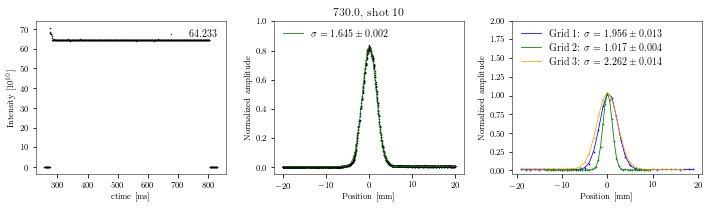

Recorded intensities: [ 61.918  64.317  62.986  59.507  64.233]
Intensities after outlier exclusion: [61.917999999999999, 64.317000000000007, 62.986000000000004, 0, 64.233000000000004]
Beta wire: 4.27416812375
Beta rel: 0.91195 Gamma rel: 2.43728
1.38494112821 61.918
1.38322989414 64.317
1.41923983332 62.986
1.33051018024 0
An intensity value was excluded.
1.40793850925 64.233

Normal emittance: [ 1.38494113  1.38322989  1.41923983  1.33051018  1.40793851] 1.38517190903 0.0305636085137
Normalized emittance: [1.1338184977189769, 1.0901788005951218, 1.1421967189969946, 1.1111037844208023] 1.11932445043 0.0203117350942
Intensity: [ 61.918  64.317  62.986  59.507  64.233]

Outliers excluded: [1.1338184977189769, 1.0901788005951218, 1.1421967189969946, 1.1111037844208023] 1.11932445043 0.0203117350942

PROFILE_NOQSTRIP_TUNE_300_V_R3_2018_10_15_13_05


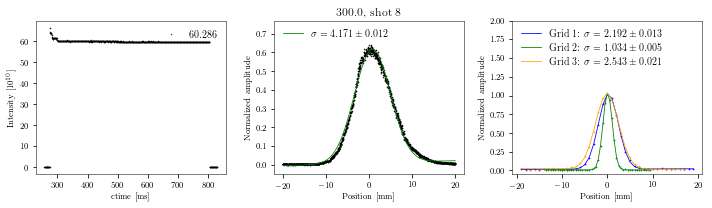

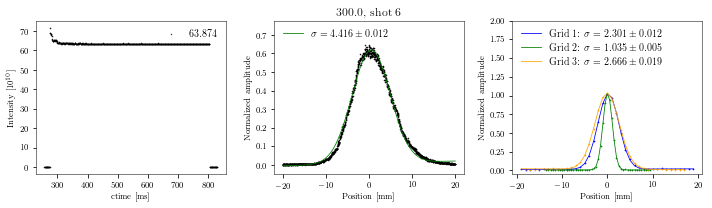

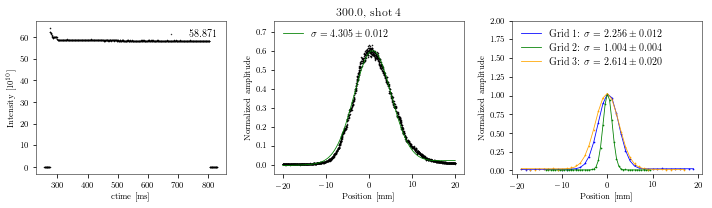

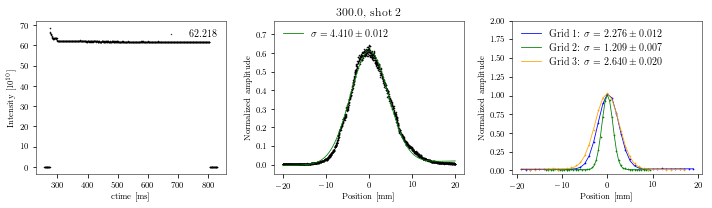

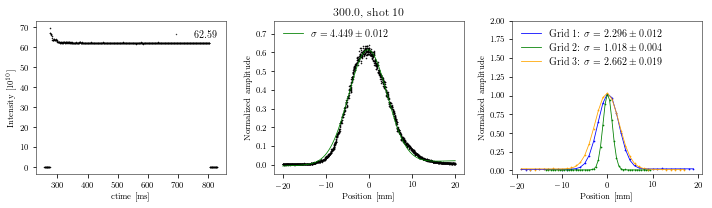

Recorded intensities: [ 60.286  63.874  58.871  62.218  62.59 ]
Intensities after outlier exclusion: [60.286000000000001, 0, 0, 62.218000000000004, 62.590000000000003]
Beta wire: 4.0617395833500005
Beta rel: 0.34446 Gamma rel: 1.06519
1.57188179708 60.286
1.76196418883 0
An intensity value was excluded.
1.67396920499 0
An intensity value was excluded.
1.75721853199 62.218
1.78779463696 62.59

Normal emittance: [ 1.5718818   1.76196419  1.6739692   1.75721853  1.78779464] 1.71056567197 0.0791898080147
Normalized emittance: [0.96521875509740829, 1.0455193254668076, 1.0573895527534751] 1.02270921111 0.0409397115525
Intensity: [ 60.286  63.874  58.871  62.218  62.59 ]

Outliers excluded: [0.96521875509740829, 1.0455193254668076, 1.0573895527534751] 1.02270921111 0.0409397115525

PROFILE_NOQSTRIP_TUNE_450_V_R3_2018_10_15_14_15


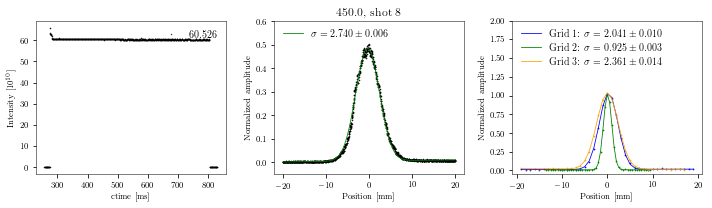

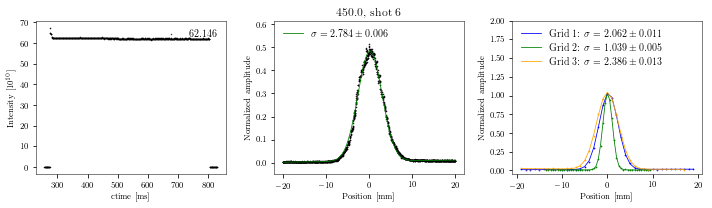

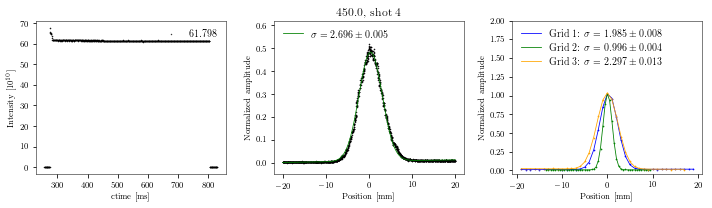

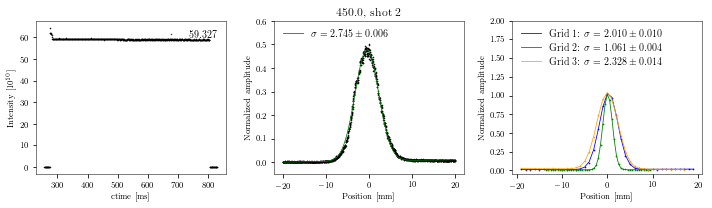

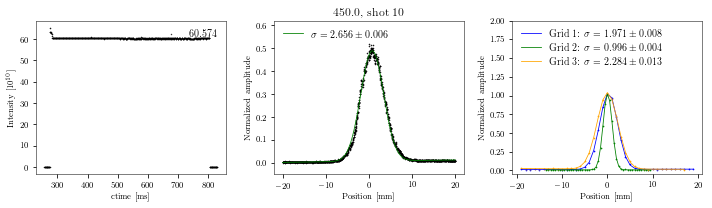

Recorded intensities: [ 60.526  62.146  61.798  59.327  60.574]
Intensities after outlier exclusion: [60.526000000000003, 0, 61.798000000000002, 0, 60.573999999999998]
Beta wire: 4.2173975723999995
Beta rel: 0.62059 Gamma rel: 1.27529
1.40916918161 60.526
1.45442238078 0
An intensity value was excluded.
1.36414326324 61.798
1.41384934266 0
An intensity value was excluded.
1.32368053636 60.574

Normal emittance: [ 1.40916918  1.45442238  1.36414326  1.41384934  1.32368054] 1.39305294093 0.0449593853743
Normalized emittance: [0.85164796939408749, 0.8074665023462414, 0.79934798011912256] 0.819487483953 0.0229811548685
Intensity: [ 60.526  62.146  61.798  59.327  60.574]

Outliers excluded: [0.85164796939408749, 0.8074665023462414, 0.79934798011912256] 0.819487483953 0.0229811548685

PROFILE_NOQSTRIP_TUNE_310_V_R3_2018_10_15_13_11


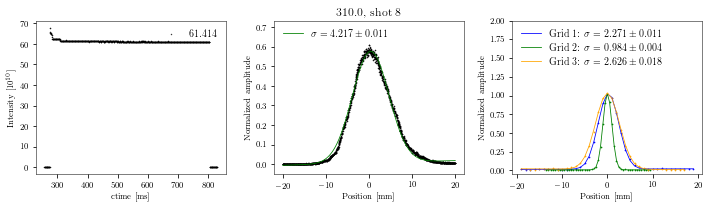

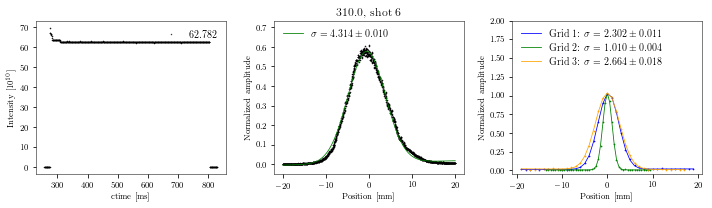

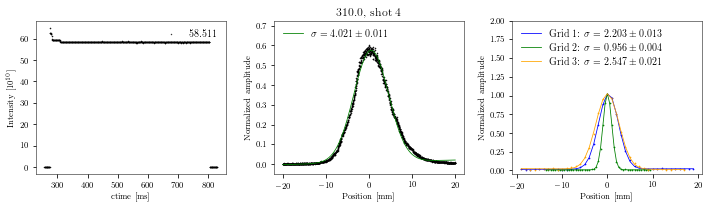

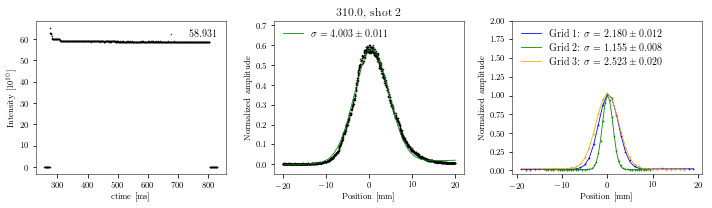

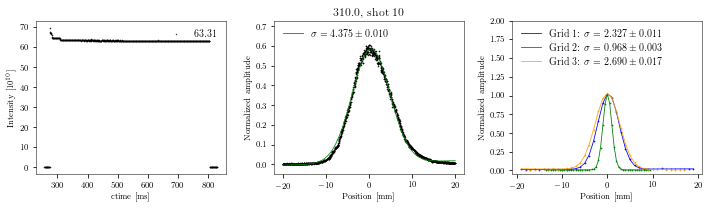

Recorded intensities: [ 61.414  62.782  58.511  58.931  63.31 ]
Intensities after outlier exclusion: [61.414000000000001, 62.782000000000004, 0, 0, 0]
Beta wire: 4.0772626059
Beta rel: 0.35976 Gamma rel: 1.07176
1.6820518631 61.414
1.76000778699 62.782
1.52870633157 0
An intensity value was excluded.
1.51530582252 0
An intensity value was excluded.
1.80994194338 0
An intensity value was excluded.

Normal emittance: [ 1.68205186  1.76000779  1.52870633  1.51530582  1.80994194] 1.65920274951 0.119282591216
Normalized emittance: [0.68031430354621802, 0.69633311176170443] 0.688323707654 0.00800940410774
Intensity: [ 61.414  62.782  58.511  58.931  63.31 ]

Outliers excluded: [0.68031430354621802, 0.69633311176170443] 0.688323707654 0.00800940410774

PROFILE_NOQSTRIP_TUNE_500_V_R3_2018_10_15_14_21


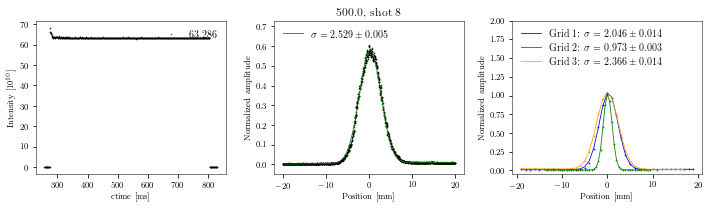

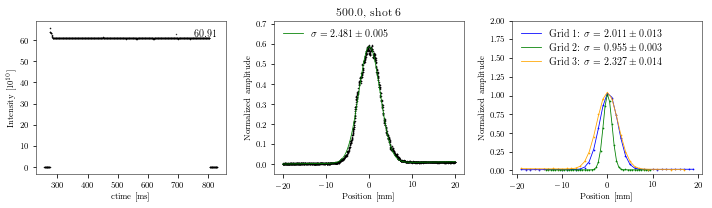

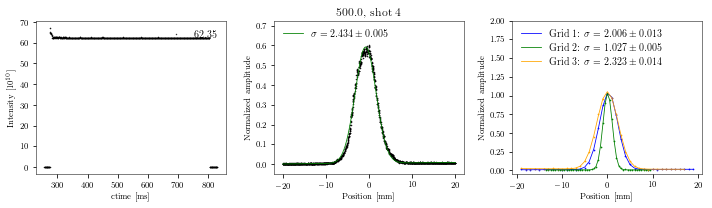

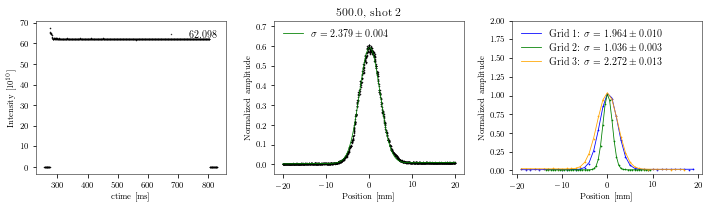

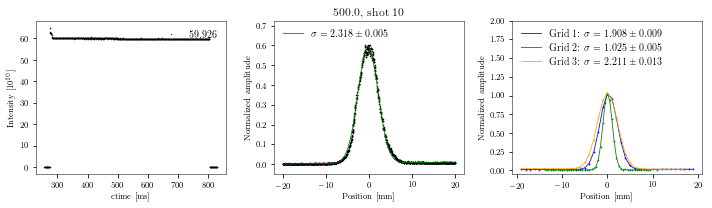

Recorded intensities: [ 63.286  60.91   62.35   62.098  59.926]
Intensities after outlier exclusion: [0, 60.910000000000004, 62.350000000000001, 62.097999999999999, 0]
Beta wire: 4.23680314735
Beta rel: 0.71309 Gamma rel: 1.42638
1.53501607907 0
An intensity value was excluded.
1.47779351141 60.91
1.42195862758 62.35
1.35903019696 62.098
1.2902364383 0
An intensity value was excluded.

Normal emittance: [ 1.53501608  1.47779351  1.42195863  1.3590302   1.29023644] 1.41680697066 0.0861133511998
Normalized emittance: [0.8994281716895971, 0.84545760157697025, 0.81132119954654991] 0.852068990938 0.0362720506452
Intensity: [ 63.286  60.91   62.35   62.098  59.926]

Outliers excluded: [0.8994281716895971, 0.84545760157697025, 0.81132119954654991] 0.852068990938 0.0362720506452

PROFILE_NOQSTRIP_TUNE_600_V_R3_2018_10_15_14_33


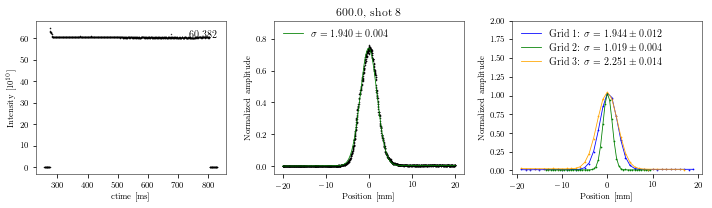

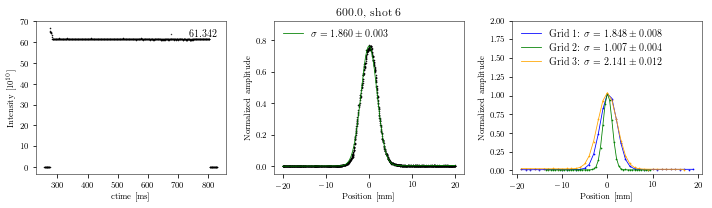

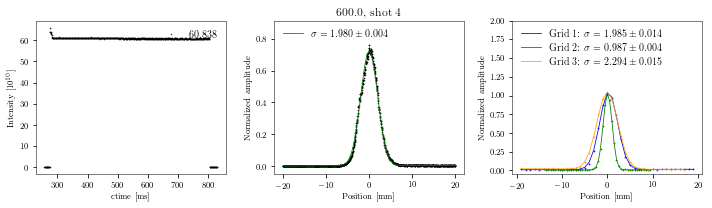

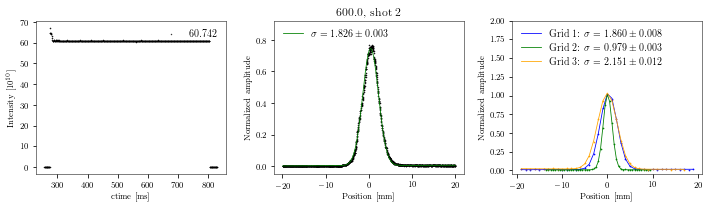

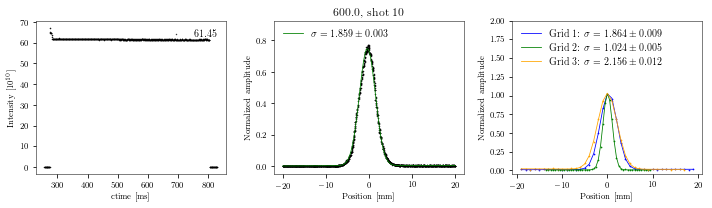

Recorded intensities: [ 60.382  61.342  60.838  60.742  61.45 ]
Intensities after outlier exclusion: [0, 61.341999999999999, 60.838000000000001, 60.742000000000004, 0]
Beta wire: 4.2573713246
Beta rel: 0.84468 Gamma rel: 1.86823
1.39470306019 0
An intensity value was excluded.
1.28263127074 61.342
1.45310276421 60.838
1.23582890951 60.742
1.2814417094 0
An intensity value was excluded.

Normal emittance: [ 1.39470306  1.28263127  1.45310276  1.23582891  1.28144171] 1.32954154281 0.0810057084665
Normalized emittance: [0.76496194224832914, 0.87381065727099094, 0.74432944514609123] 0.794367348222 0.0568029019134
Intensity: [ 60.382  61.342  60.838  60.742  61.45 ]

Outliers excluded: [0.76496194224832914, 0.87381065727099094, 0.74432944514609123] 0.794367348222 0.0568029019134

PROFILE_NOQSTRIP_TUNE_300_V_R3_2018_10_15_15_00


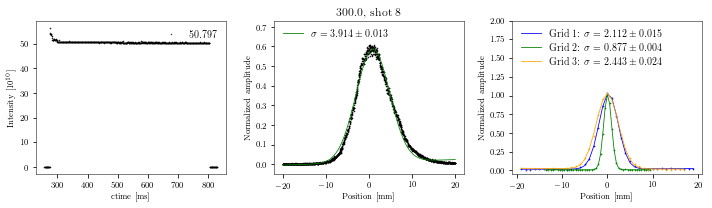

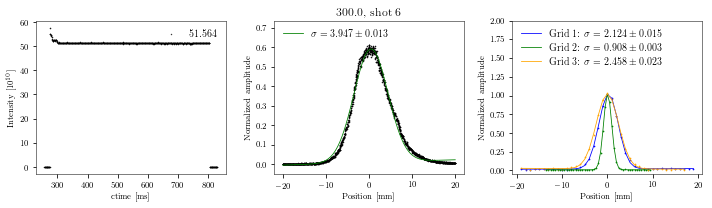

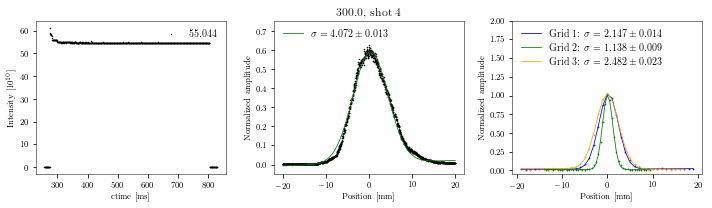

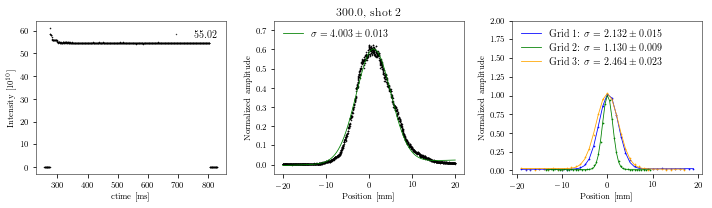

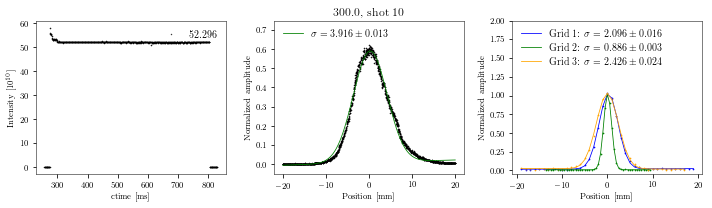

Recorded intensities: [ 50.797  51.564  55.044  55.02   52.296]
Intensities after outlier exclusion: [0, 51.564, 0, 0, 52.295999999999999]
Beta wire: 4.0617395833500005
Beta rel: 0.34446 Gamma rel: 1.06519
1.38355430877 0
An intensity value was excluded.
1.40728483018 51.564
1.49803920184 0
An intensity value was excluded.
1.44755303933 0
An intensity value was excluded.
1.38499099196 52.296

Normal emittance: [ 1.38355431  1.40728483  1.4980392   1.44755304  1.38499099] 1.42428447442 0.0435272282396
Normalized emittance: [0.56690948127647156, 0.5501191847382142] 0.558514333007 0.00839514826913
Intensity: [ 50.797  51.564  55.044  55.02   52.296]

Outliers excluded: [0.56690948127647156, 0.5501191847382142] 0.558514333007 0.00839514826913

PROFILE_NOQSTRIP_TUNE_350_V_R3_2018_10_15_13_58


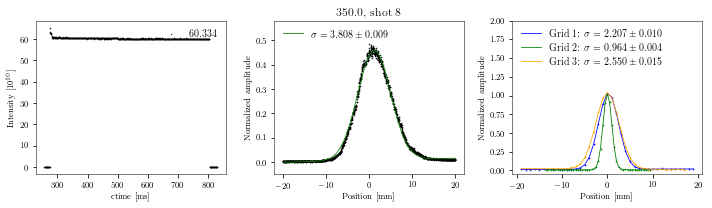

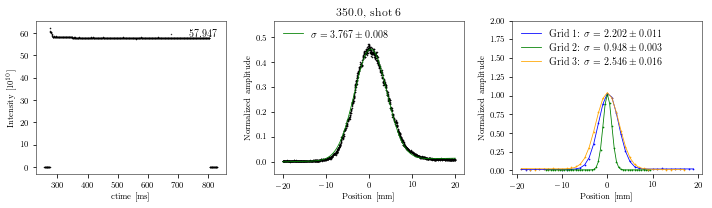

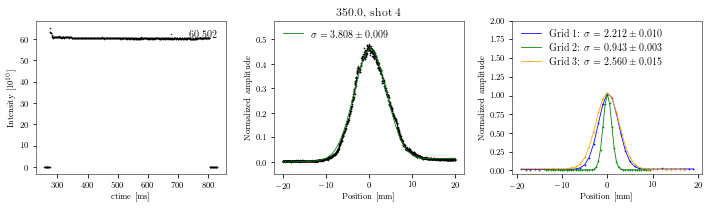

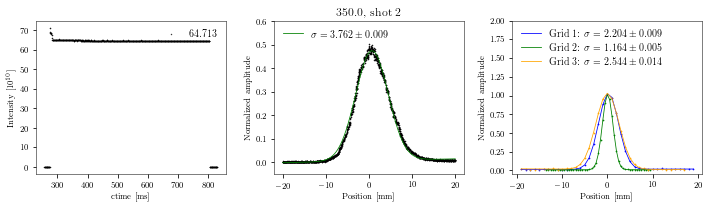

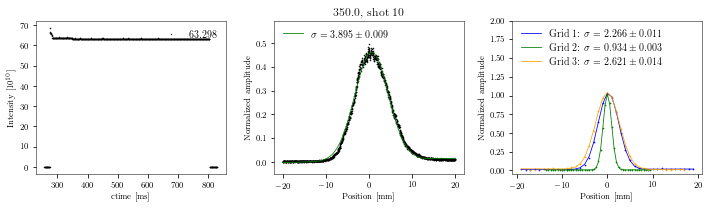

Recorded intensities: [ 60.334  57.947  60.502  64.713  63.298]
Intensities after outlier exclusion: [60.334000000000003, 0, 60.502000000000002, 0, 63.298000000000002]
Beta wire: 4.12935683535
Beta rel: 0.4273 Gamma rel: 1.10606
1.65925098709 60.334
1.62425465693 0
An intensity value was excluded.
1.65944037055 60.502
1.62014460128 0
An intensity value was excluded.
1.73664419628 63.298

Normal emittance: [ 1.65925099  1.62425466  1.65944037  1.6201446   1.7366442 ] 1.65994696243 0.0418123793183
Normalized emittance: [1.0127772773469841, 1.0100803054129026, 1.0103802408825691] 1.01107927455 0.00120689697208
Intensity: [ 60.334  57.947  60.502  64.713  63.298]

Outliers excluded: [1.0127772773469841, 1.0100803054129026, 1.0103802408825691] 1.01107927455 0.00120689697208

PROFILE_NOQSTRIP_TUNE_675_V_R3_2018_10_15_14_41


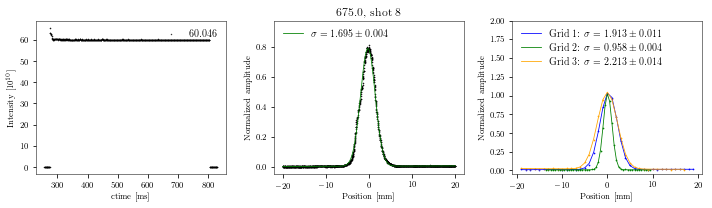

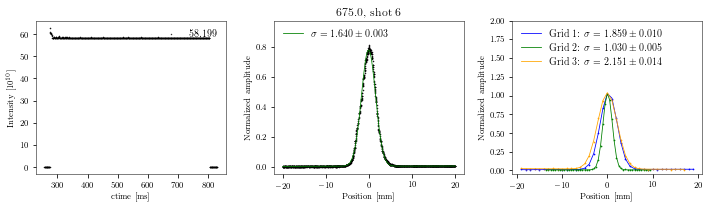

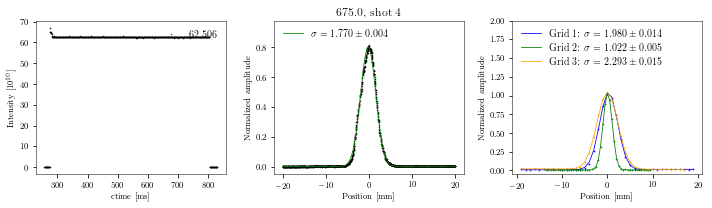

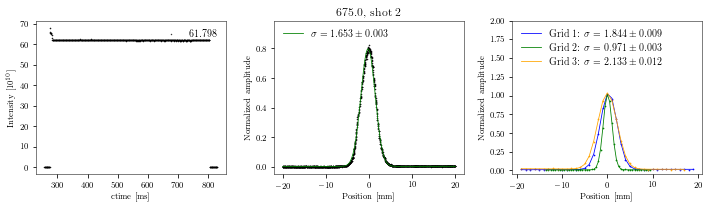

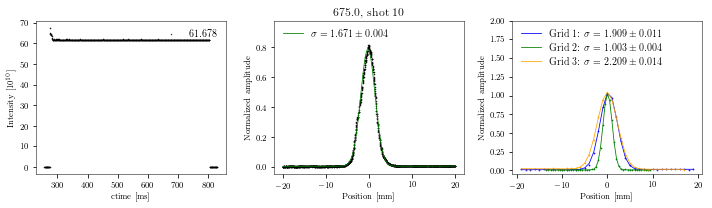

Recorded intensities: [ 60.046  58.199  62.506  61.798  61.678]
Intensities after outlier exclusion: [60.045999999999999, 0, 0, 61.798000000000002, 61.678000000000004]
Beta wire: 4.2721519221
Beta rel: 0.89503 Gamma rel: 2.24208
1.34972048501 60.046
1.26280670286 0
An intensity value was excluded.
1.47215610505 0
An intensity value was excluded.
1.28312409852 61.798
1.31199954412 61.678

Normal emittance: [ 1.34972049  1.2628067   1.47215611  1.2831241   1.31199954] 1.33596138711 0.0741024571568
Normalized emittance: [0.8250454746352941, 0.7621007178475947, 0.78076714658486723] 0.789304446356 0.0263966502585
Intensity: [ 60.046  58.199  62.506  61.798  61.678]

Outliers excluded: [0.8250454746352941, 0.7621007178475947, 0.78076714658486723] 0.789304446356 0.0263966502585

PROFILE_NOQSTRIP_TUNE_795_V_R3_2018_10_15_14_53


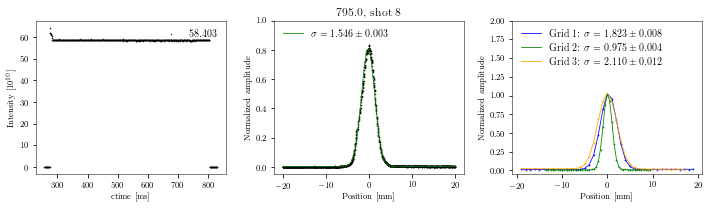

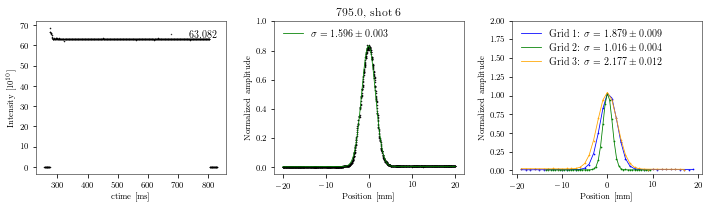

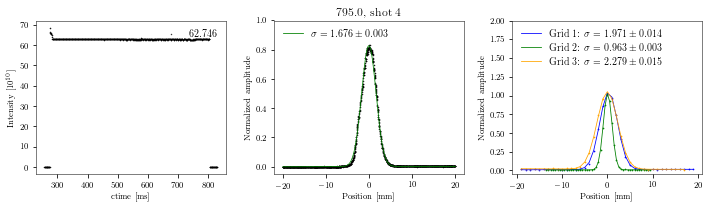

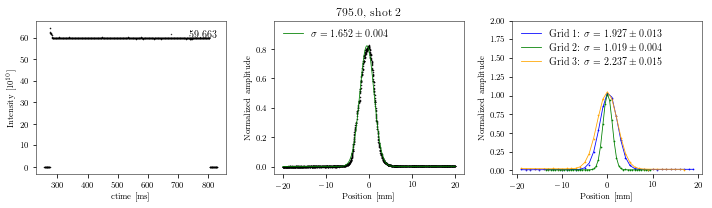

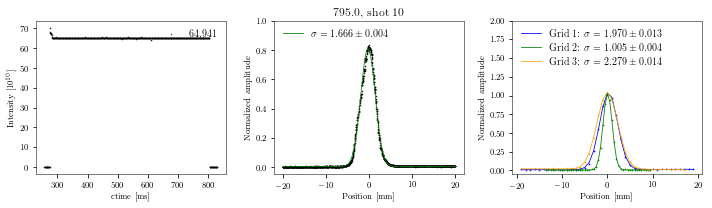

Recorded intensities: [ 58.403  63.082  62.746  59.663  64.941]
Intensities after outlier exclusion: [0, 63.082000000000001, 62.746000000000002, 59.663000000000004, 0]
Beta wire: 4.2778363301
Beta rel: 0.91495 Gamma rel: 2.47794
1.26736925792 0
An intensity value was excluded.
1.35070535204 63.082
1.4886131717 62.746
1.44661631823 59.663
1.47170636742 0
An intensity value was excluded.

Normal emittance: [ 1.26736926  1.35070535  1.48861317  1.44661632  1.47170637] 1.40500209346 0.0837412082806
Normalized emittance: [0.79434287579611862, 0.88013370041921768, 0.89949988262159952] 0.857992152946 0.0456959889889
Intensity: [ 58.403  63.082  62.746  59.663  64.941]

Outliers excluded: [0.79434287579611862, 0.88013370041921768, 0.89949988262159952] 0.857992152946 0.0456959889889

PROFILE_NOQSTRIP_TUNE_285_V_R3_2018_10_15_13_01


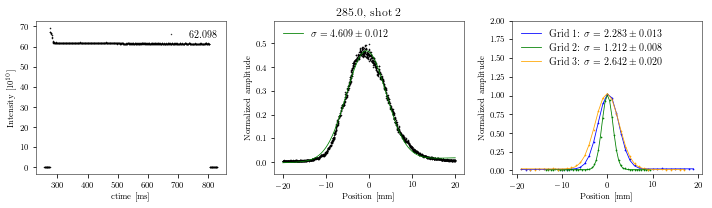

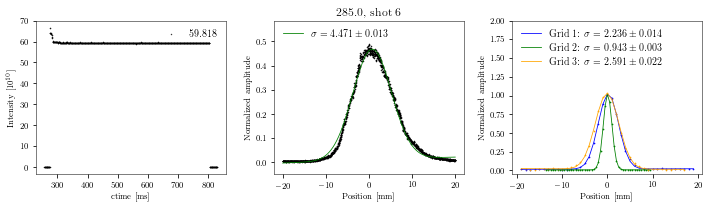

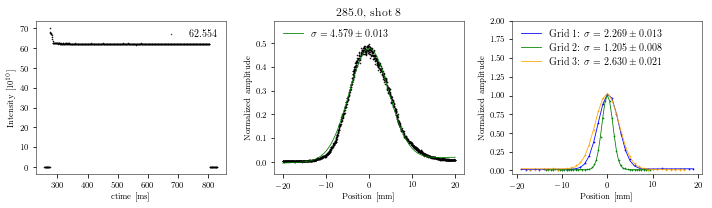

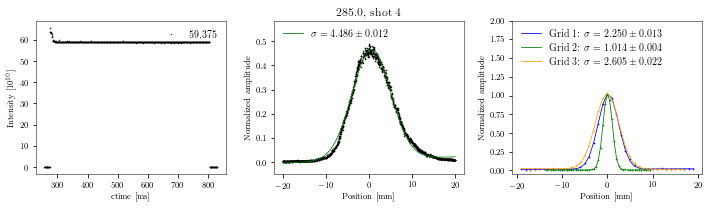

Recorded intensities: [ 62.098  59.818  62.554  59.375]
Intensities after outlier exclusion: [62.097999999999999, 59.817999999999998, 0, 0]
Beta wire: 4.0514924652
Beta rel: 0.32403 Gamma rel: 1.05703
1.79588337007 62.098
1.68973300028 59.818
1.77223556351 0
An intensity value was excluded.
1.70095662454 0
An intensity value was excluded.

Normal emittance: [ 1.79588337  1.689733    1.77223556  1.70095662] 1.7397021396 0.0453124821368
Normalized emittance: [0.88145720049568088, 0.86096780426668473] 0.871212502381 0.0102446981145
Intensity: [ 62.098  59.818  62.554  59.375]

Outliers excluded: [0.88145720049568088, 0.86096780426668473] 0.871212502381 0.0102446981145

PROFILE_NOQSTRIP_TUNE_340_V_R3_2018_10_15_13_54


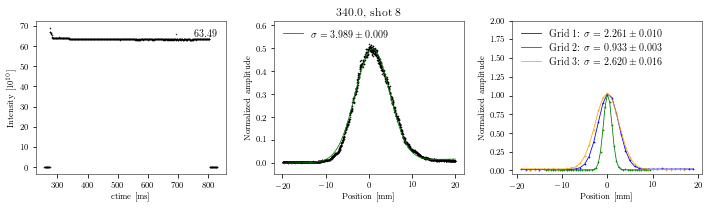

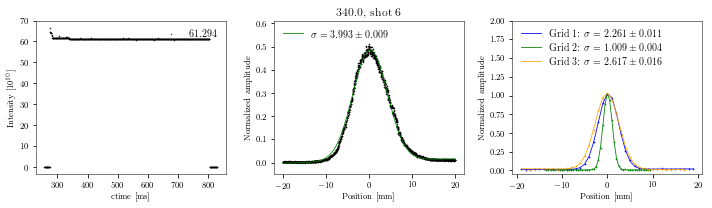

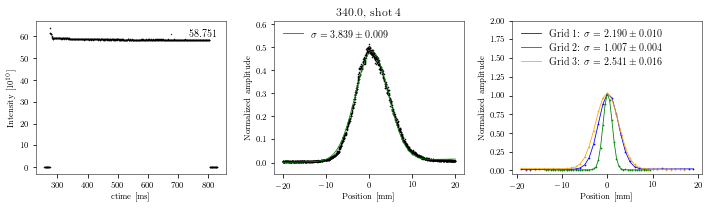

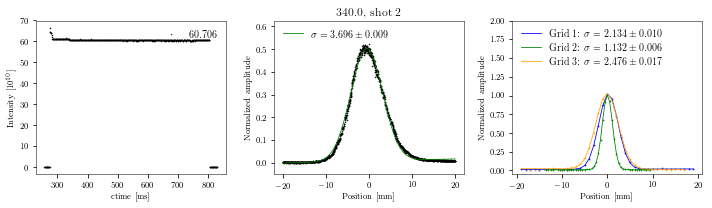

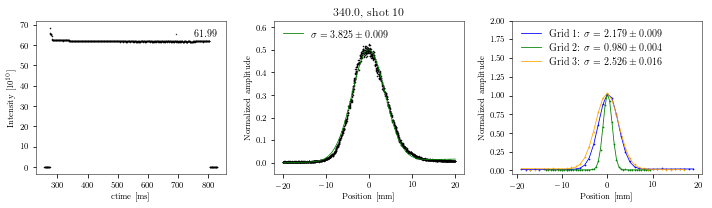

Recorded intensities: [ 63.49   61.294  58.751  60.706  61.99 ]
Intensities after outlier exclusion: [0, 61.294000000000004, 0, 60.706000000000003, 61.990000000000002]
Beta wire: 4.11765551955
Beta rel: 0.40967 Gamma rel: 1.09621
1.73525325648 0
An intensity value was excluded.
1.73876785852 61.294
1.60717996687 0
An intensity value was excluded.
1.48961390111 60.706
1.59525997755 61.99

Normal emittance: [ 1.73525326  1.73876786  1.60717997  1.4896139   1.59525998] 1.6332149921 0.0941200233846
Normalized emittance: [1.043873456746782, 0.90295542999055411, 0.94696526300663031] 0.964598049915 0.0588651506798
Intensity: [ 63.49   61.294  58.751  60.706  61.99 ]

Outliers excluded: [1.043873456746782, 0.90295542999055411, 0.94696526300663031] 0.964598049915 0.0588651506798

PROFILE_NOQSTRIP_TUNE_320_V_R3_2018_10_15_13_14


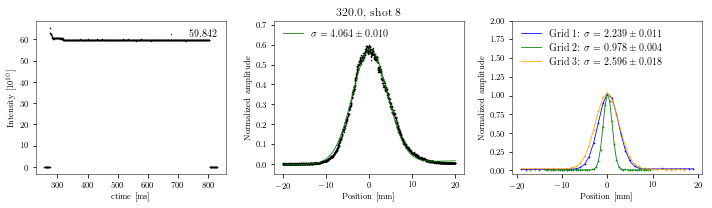

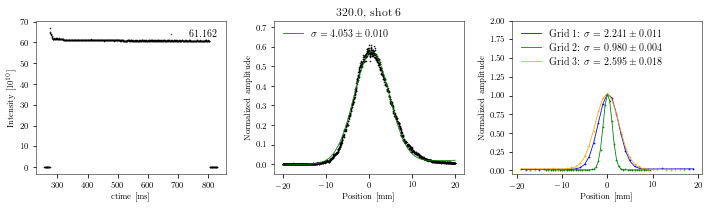

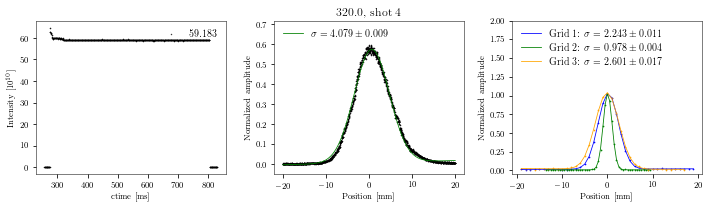

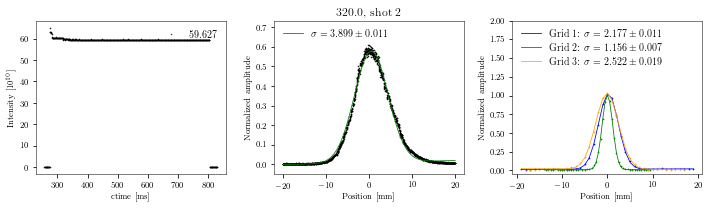

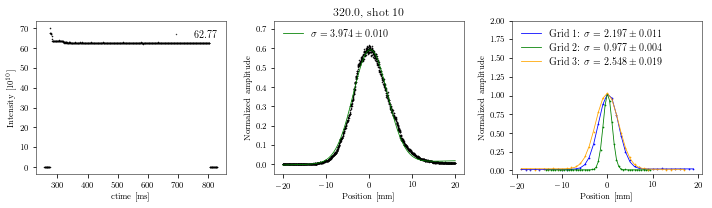

Recorded intensities: [ 59.842  61.162  59.183  59.627  62.77 ]
Intensities after outlier exclusion: [59.841999999999999, 61.161999999999999, 0, 59.627000000000002, 0]
Beta wire: 4.0911189776
Beta rel: 0.37581 Gamma rel: 1.0791
1.63734697179 59.842
1.62821354663 61.162
1.6492239482 0
An intensity value was excluded.
1.50686519486 59.627
1.56570313654 0
An intensity value was excluded.

Normal emittance: [ 1.63734697  1.62821355  1.64922395  1.50686519  1.56570314] 1.5974705596 0.053725550756
Normalized emittance: [0.98845500104276585, 0.96172735077646165, 0.9129641505122964] 0.954382167444 0.0312535962421
Intensity: [ 59.842  61.162  59.183  59.627  62.77 ]

Outliers excluded: [0.98845500104276585, 0.96172735077646165, 0.9129641505122964] 0.954382167444 0.0312535962421

PROFILE_NOQSTRIP_TUNE_325_V_R3_2018_10_15_13_51


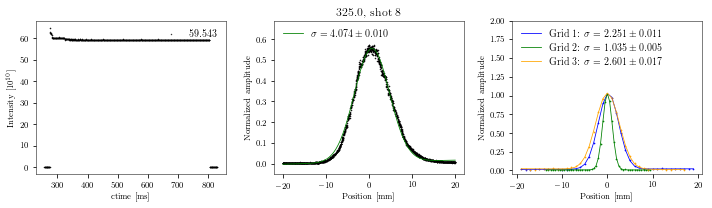

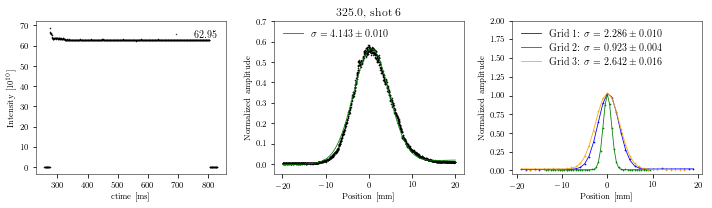

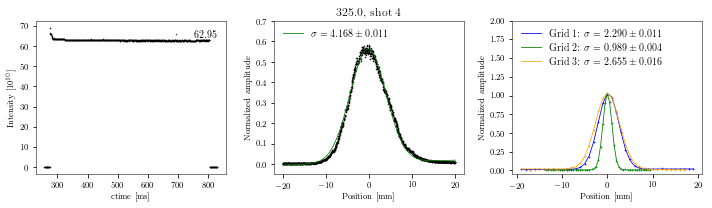

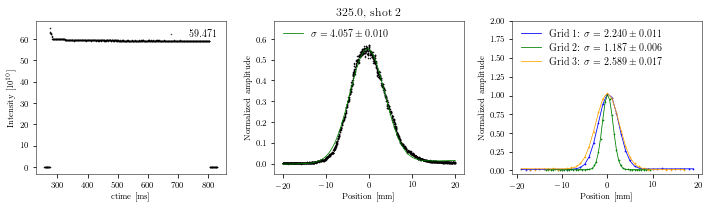

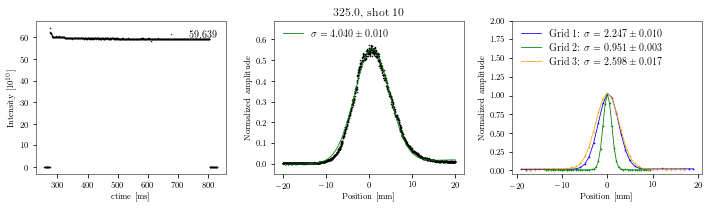

Recorded intensities: [ 59.543  62.95   62.95   59.471  59.639]
Intensities after outlier exclusion: [59.542999999999999, 0, 0, 59.471000000000004, 59.639000000000003]
Beta wire: 4.0982071433
Beta rel: 0.38404 Gamma rel: 1.08305
1.68475357749 59.543
1.74205245548 0
An intensity value was excluded.
1.762872536 0
An intensity value was excluded.
1.67039993411 59.471
1.65621243279 59.639

Normal emittance: [ 1.68475358  1.74205246  1.76287254  1.67039993  1.65621243] 1.70325818717 0.0416995304964
Normalized emittance: [1.0109879612354238, 1.0035881671038382, 0.99226117055971608] 1.00227909963 0.00770101359066
Intensity: [ 59.543  62.95   62.95   59.471  59.639]

Outliers excluded: [1.0109879612354238, 1.0035881671038382, 0.99226117055971608] 1.00227909963 0.00770101359066

PROFILE_NOQSTRIP_TUNE_430_V_R3_2018_10_15_14_11


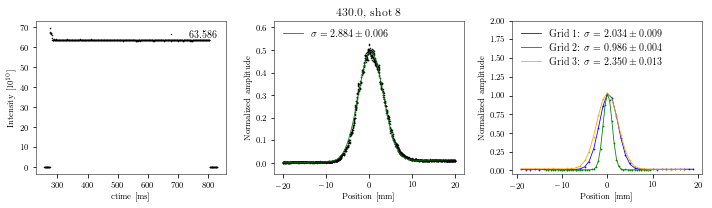

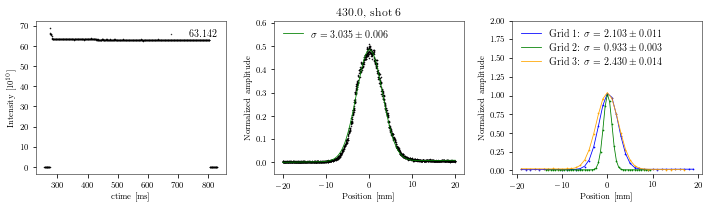

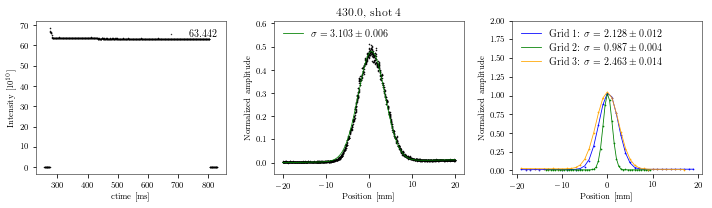

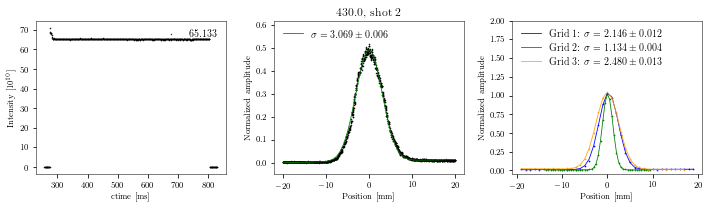

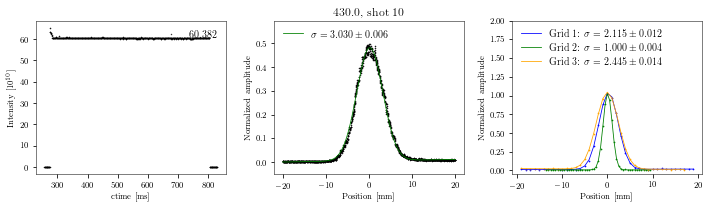

Recorded intensities: [ 63.586  63.142  63.442  65.133  60.382]
Intensities after outlier exclusion: [63.585999999999999, 63.142000000000003, 63.442, 0, 0]
Beta wire: 4.2039435334499995
Beta rel: 0.58113 Gamma rel: 1.22879
1.41272171459 63.586
1.56511970696 63.142
1.63591714257 63.442
1.60008802456 0
An intensity value was excluded.
1.55994195849 0
An intensity value was excluded.

Normal emittance: [ 1.41272171  1.56511971  1.63591714  1.60008802  1.55994196] 1.55475770943 0.0760922628387
Normalized emittance: [0.84502025119621405, 0.94276017443814708, 0.98074576148870762] 0.922842062374 0.0571716825429
Intensity: [ 63.586  63.142  63.442  65.133  60.382]

Outliers excluded: [0.84502025119621405, 0.94276017443814708, 0.98074576148870762] 0.922842062374 0.0571716825429

PROFILE_NOQSTRIP_TUNE_470_V_R3_2018_10_15_14_18


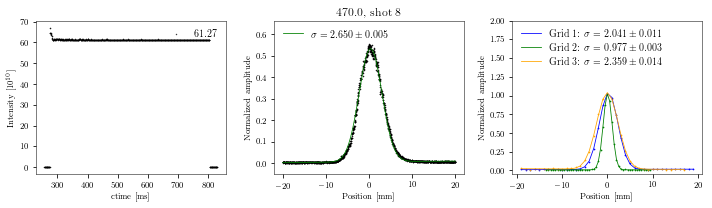

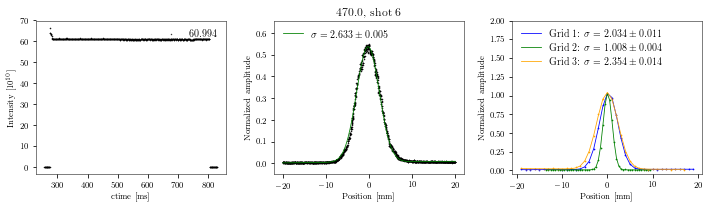

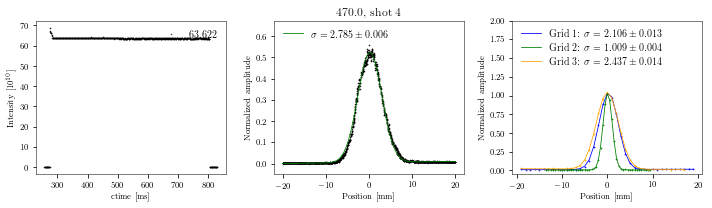

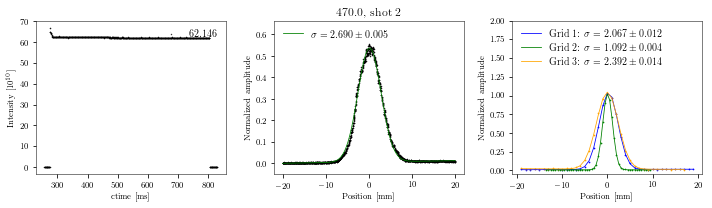

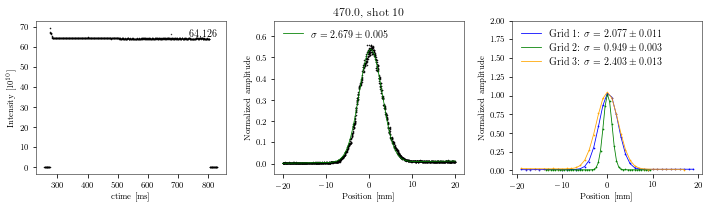

Recorded intensities: [ 61.27   60.994  63.622  62.146  64.126]
Intensities after outlier exclusion: [61.270000000000003, 0, 63.622, 62.146000000000001, 0]
Beta wire: 4.228233595200001
Beta rel: 0.65911 Gamma rel: 1.32971
1.45610820455 61.27
1.43686644045 0
An intensity value was excluded.
1.60750378424 63.622
1.50036400417 62.146
1.48781774596 0
An intensity value was excluded.

Normal emittance: [ 1.4561082   1.43686644  1.60750378  1.500364    1.48781775] 1.49773203587 0.059316475251
Normalized emittance: [0.88900788759033766, 0.94515825593915326, 0.90311551061021123] 0.912427218047 0.0238501836186
Intensity: [ 61.27   60.994  63.622  62.146  64.126]

Outliers excluded: [0.88900788759033766, 0.94515825593915326, 0.90311551061021123] 0.912427218047 0.0238501836186


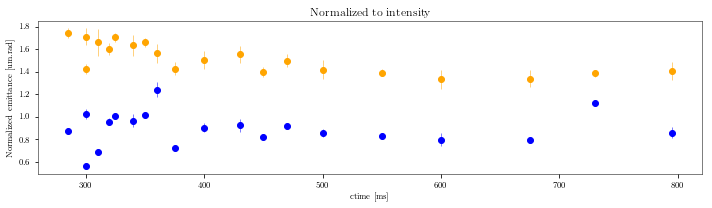

In [5]:
emittance_norm = []
error_norm = []
emittance = []
error = []
ctime = []
beta_rel = []
gamma_rel = []
sigma = []
sigma_err = []
intensity = []
intensity_err = []
beta_wire = []
for directory in result_folders:
    print("")
    print(directory)
    cycle_time = float(re.search('TUNE_(.*)_V', directory).group(1))
    data_dict = get_data(directory, cycle_time)
    beta_w, beta, gamma, em_norm, err_norm, em, err, sig, sig_err, intt, int_err = calculate_emittance(data_dict, cycle_time, madx_folder, plane)
    emittance.append(em)
    emittance_norm.append(em_norm)
    ctime.append(cycle_time)
    error.append(err)
    error_norm.append(err_norm)
    beta_rel.append(beta)
    gamma_rel.append(gamma)
    sigma.append(sig)
    sigma_err.append(sig_err)
    intensity.append(intt)
    intensity_err.append(int_err)
    beta_wire.append(beta_w)
    

# Save the data in a file
try:
    os.remove(os.path.join(data_path, "data.txt"))
except OSError:
    pass
with open(os.path.join(data_path, "data.txt"), "a") as dfile:
    dfile.write("%10s %10s %10s %10s %10s %10s %10s %10s %10s %10s \n" % ("# ctime", "b_rel", "g_rel", "beta_y", "int", "int_err", "sigma", "sigma_err", "em", "em_err"))
    for ct, brel, grel, beta, i, i_err, s, s_err, em, err in zip(ctime, beta_rel, gamma_rel, beta_wire, intensity, intensity_err, sigma, sigma_err, emittance_norm, error_norm):
        dfile.write("%10.0f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f \n" % (ct, brel, grel, beta, i, i_err, s, s_err, em, err))

plt.errorbar(ctime, emittance_norm, yerr=error_norm, fmt='o', color="blue")
plt.xlabel("ctime [ms]")
plt.ylabel("Normalized emittance [um.rad]")
plt.title("Normalized to intensity")
# plt.show()

plt.errorbar(ctime, emittance, yerr=error, fmt='o', color="orange")
plt.xlabel("ctime [ms]")
plt.ylabel("Normalized emittance [um.rad]")
# plt.show()

# plt.scatter(ctime, gamma_rel)
# plt.scatter(ctime, beta_rel)
# plt.xlabel("ctime [ms]")
# plt.ylabel("Normalized emittance [um.rad]")
# plt.show()

plt.savefig(os.path.join(data_path, "emittance.png"), dpi=1000)

A low standard deviation indicates that the data points tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the data points are spread out over a wider range of values.